[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

This demo solves DoomBasic env with a simple q-learning with experience replay.

Video observation forces you to use ```CNN```

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=gpu,floatX=float32

env: THEANO_FLAGS=device=gpu,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=48,height=48,grayscale=True)

env = make_env()

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-03-18 22:22:45,784] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 730M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5004)
[2017-03-18 22:22:50,552] Making new env: ppaquette/DoomBasic-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
SEQ_LENGTH = 3
FRAME_NUMBER = 2

-10.0 False


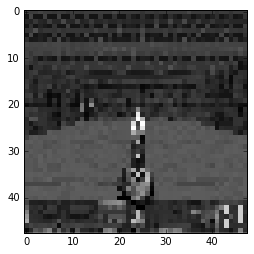

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0], cmap='gray', interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=gpu0,floatX=float32

import theano, lasagne
from lasagne.layers import *

from agentnet.memory import WindowAugmentation, LSTMCell
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.target_network import TargetNetwork
from agentnet.experiments.openai_gym.pool import EnvPool

env: THEANO_FLAGS=device=gpu0,floatX=float32


Now, define your NN which probably solve the environment. 

#### Tips:
1. Main component are likely to be ```Conv2D``` and ```Pool2DLayer```
2. Batch normalization here might speeds up training but may get unstable if you use small experience replay buffer
3. Last layers should be Dense

In [6]:
from lasagne.nonlinearities import rectify, tanh, softmax

#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images

prev_wnd = InputLayer((None,FRAME_NUMBER)+observation_shape) 
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,FRAME_NUMBER*observation_shape[0])+observation_shape[1:])


layer = Conv2DLayer(wnd_reshape, num_filters=20, filter_size=(3, 3), 
                    nonlinearity=rectify, pad='same')

layer = Conv2DLayer(layer, num_filters=40, filter_size=(3, 3), 
                    nonlinearity=rectify, pad='same')


layer = FlattenLayer(layer)

layer = DenseLayer(layer, num_units=256, nonlinearity=tanh)  

dense = DenseLayer(layer, num_units=128, nonlinearity=tanh)  

In [7]:
#baseline for all qvalues
qvalues_layer = DenseLayer(dense, num_units=n_actions, 
                           nonlinearity=None, name='qval')
        
#sample actions proportionally to policy_layer
action_layer = EpsilonGreedyResolver(qvalues_layer)

In [8]:
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [9]:
from agentnet.agent import Agent
#all together

agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)

In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, W, b, qval.W, qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [11]:
pool = EnvPool(agent,make_env, 
               n_games=5, #parallel games (only 1 so far)
               max_size=int(1e4)) #experience replay pool holding last 1k sessions

[2017-03-18 22:22:52,036] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:22:52,052] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:22:52,070] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:22:52,095] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:22:52,115] Making new env: ppaquette/DoomBasic-v0


# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(128)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

In [13]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [14]:
# Compute weight updates
updates = lasagne.updates.adam(loss, weights)

train_step = theano.function([],loss,updates=updates)

# Training loop

If you don't have ```tqdm```, remove the first line and ```tqdm_notebook``` from second line

Loop may take years to finish.

You may consider interrupting early.

In [15]:
from tqdm import trange, tqdm_notebook
#the loop may take eons to finish.
#consider interrupting early.

epoch_counter = 1
rewards = {}
action_layer.epsilon.set_value(1.0)

for i in tqdm_notebook(range(10000)):  
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.05)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 1.0 * np.exp(-epoch_counter/300.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter % 10 == 0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 == 0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  += 1

    
# Time to drink some coffee!

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/usr/local/lib/python3.4/dist-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] Warning! Appending sessions to empty or broken pool. Old pool sessions, if any, are disposed.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


iter=10	epsilon=0.967	reward/step=-0.89333
iter=20	epsilon=0.936	reward/step=-2.07667
iter=30	epsilon=0.905	reward/step=-2.45556
iter=40	epsilon=0.875	reward/step=-2.64000
iter=50	epsilon=0.846	reward/step=-2.46400
iter=60	epsilon=0.819	reward/step=-2.47889
iter=70	epsilon=0.792	reward/step=-2.57619
iter=80	epsilon=0.766	reward/step=-2.75000
iter=90	epsilon=0.741	reward/step=-2.90741


[2017-03-18 22:25:53,097] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:25:53,107] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.717	reward/step=-2.85867


[2017-03-18 22:25:54,031] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 26 timesteps with reward=-49.0
iter=110	epsilon=0.693	reward/step=-2.89758
iter=120	epsilon=0.670	reward/step=-2.91056
iter=130	epsilon=0.648	reward/step=-2.93128
iter=140	epsilon=0.627	reward/step=-2.99810
iter=150	epsilon=0.607	reward/step=-2.91244
iter=160	epsilon=0.587	reward/step=-2.97833
iter=170	epsilon=0.567	reward/step=-2.90353
iter=180	epsilon=0.549	reward/step=-2.96259
iter=190	epsilon=0.531	reward/step=-3.03825


[2017-03-18 22:28:53,936] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:28:53,947] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.513	reward/step=-3.01833


[2017-03-18 22:28:55,857] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 70 timesteps with reward=-435.0
iter=210	epsilon=0.497	reward/step=-3.03302
iter=220	epsilon=0.480	reward/step=-3.09364
iter=230	epsilon=0.465	reward/step=-3.10957
iter=240	epsilon=0.449	reward/step=-3.12389
iter=250	epsilon=0.435	reward/step=-3.12480
iter=260	epsilon=0.420	reward/step=-3.10769
iter=270	epsilon=0.407	reward/step=-3.04617
iter=280	epsilon=0.393	reward/step=-3.01786
iter=290	epsilon=0.380	reward/step=-3.01103


[2017-03-18 22:31:59,533] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:31:59,543] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.368	reward/step=-3.03400


[2017-03-18 22:32:01,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 70 timesteps with reward=-390.0
iter=310	epsilon=0.356	reward/step=-2.91505
iter=320	epsilon=0.344	reward/step=-2.94792
iter=330	epsilon=0.333	reward/step=-2.96768
iter=340	epsilon=0.322	reward/step=-2.94353
iter=350	epsilon=0.311	reward/step=-2.92076
iter=360	epsilon=0.301	reward/step=-2.90222
iter=370	epsilon=0.291	reward/step=-2.92018
iter=380	epsilon=0.282	reward/step=-2.93632
iter=390	epsilon=0.273	reward/step=-2.91709


[2017-03-18 22:35:09,505] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:35:09,516] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.264	reward/step=-2.91650


[2017-03-18 22:35:11,476] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 70 timesteps with reward=-370.0
iter=410	epsilon=0.255	reward/step=-2.82943
iter=420	epsilon=0.247	reward/step=-2.83095
iter=430	epsilon=0.239	reward/step=-2.83085
iter=440	epsilon=0.231	reward/step=-2.84379
iter=450	epsilon=0.223	reward/step=-2.84400
iter=460	epsilon=0.216	reward/step=-2.76942
iter=470	epsilon=0.209	reward/step=-2.76709
iter=480	epsilon=0.202	reward/step=-2.71625
iter=490	epsilon=0.195	reward/step=-2.65279


[2017-03-18 22:38:24,024] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:38:24,035] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.189	reward/step=-2.65653


[2017-03-18 22:38:26,006] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 70 timesteps with reward=-370.0
iter=510	epsilon=0.183	reward/step=-2.67634
iter=520	epsilon=0.177	reward/step=-2.69474
iter=530	epsilon=0.171	reward/step=-2.65925
iter=540	epsilon=0.165	reward/step=-2.64284
iter=550	epsilon=0.160	reward/step=-2.67661
iter=560	epsilon=0.155	reward/step=-2.70619
iter=570	epsilon=0.150	reward/step=-2.63509
iter=580	epsilon=0.145	reward/step=-2.60012
iter=590	epsilon=0.140	reward/step=-2.57887


[2017-03-18 22:41:42,777] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:41:42,788] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.135	reward/step=-2.46478


[2017-03-18 22:41:43,332] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 10 timesteps with reward=47.0
iter=610	epsilon=0.131	reward/step=-2.44546
iter=620	epsilon=0.127	reward/step=-2.36054
iter=630	epsilon=0.122	reward/step=-2.33270
iter=640	epsilon=0.118	reward/step=-2.26344
iter=650	epsilon=0.115	reward/step=-2.17210
iter=660	epsilon=0.111	reward/step=-2.15909
iter=670	epsilon=0.107	reward/step=-2.11483
iter=680	epsilon=0.104	reward/step=-2.01971
iter=690	epsilon=0.100	reward/step=-2.00995


[2017-03-18 22:45:04,479] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:45:04,490] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.097	reward/step=-1.95962


[2017-03-18 22:45:04,928] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 5 timesteps with reward=76.0
iter=710	epsilon=0.094	reward/step=-1.94958
iter=720	epsilon=0.091	reward/step=-1.91083
iter=730	epsilon=0.088	reward/step=-1.86521
iter=740	epsilon=0.085	reward/step=-1.82910
iter=750	epsilon=0.082	reward/step=-1.79298
iter=760	epsilon=0.079	reward/step=-1.80526
iter=770	epsilon=0.077	reward/step=-1.79931
iter=780	epsilon=0.074	reward/step=-1.78402
iter=790	epsilon=0.072	reward/step=-1.75975


[2017-03-18 22:48:31,147] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:48:31,157] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.069	reward/step=-1.71883


[2017-03-18 22:48:31,701] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 11 timesteps with reward=46.0
iter=810	epsilon=0.067	reward/step=-1.67021
iter=820	epsilon=0.065	reward/step=-1.62268
iter=830	epsilon=0.063	reward/step=-1.57679
iter=840	epsilon=0.061	reward/step=-1.51516
iter=850	epsilon=0.059	reward/step=-1.46212
iter=860	epsilon=0.057	reward/step=-1.39574
iter=870	epsilon=0.055	reward/step=-1.30429
iter=880	epsilon=0.053	reward/step=-1.24886
iter=890	epsilon=0.051	reward/step=-1.12285


[2017-03-18 22:52:04,102] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:52:04,113] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.050	reward/step=-1.03896


[2017-03-18 22:52:04,420] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 1 timesteps with reward=96.0
iter=910	epsilon=0.048	reward/step=-0.94901
iter=920	epsilon=0.047	reward/step=-0.89283
iter=930	epsilon=0.045	reward/step=-0.79090
iter=940	epsilon=0.044	reward/step=-0.71369
iter=950	epsilon=0.042	reward/step=-0.62393
iter=960	epsilon=0.041	reward/step=-0.54208
iter=970	epsilon=0.039	reward/step=-0.44825
iter=980	epsilon=0.038	reward/step=-0.34857
iter=990	epsilon=0.037	reward/step=-0.28108


[2017-03-18 22:55:42,851] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:55:42,862] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.036	reward/step=-0.19300


[2017-03-18 22:55:43,362] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 9 timesteps with reward=52.0
iter=1010	epsilon=0.035	reward/step=-0.10528
iter=1020	epsilon=0.033	reward/step=-0.00627
iter=1030	epsilon=0.032	reward/step=0.08343
iter=1040	epsilon=0.031	reward/step=0.16481
iter=1050	epsilon=0.030	reward/step=0.22425
iter=1060	epsilon=0.029	reward/step=0.30208
iter=1070	epsilon=0.028	reward/step=0.37159
iter=1080	epsilon=0.027	reward/step=0.44673
iter=1090	epsilon=0.026	reward/step=0.50795


[2017-03-18 22:59:30,017] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 22:59:30,028] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.026	reward/step=0.55430


[2017-03-18 22:59:30,498] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 8 timesteps with reward=57.0
iter=1110	epsilon=0.025	reward/step=0.61165
iter=1120	epsilon=0.024	reward/step=0.68137
iter=1130	epsilon=0.023	reward/step=0.72631
iter=1140	epsilon=0.022	reward/step=0.78135
iter=1150	epsilon=0.022	reward/step=0.84887
iter=1160	epsilon=0.021	reward/step=0.90793
iter=1170	epsilon=0.020	reward/step=0.96678
iter=1180	epsilon=0.020	reward/step=1.03068
iter=1190	epsilon=0.019	reward/step=1.08667


[2017-03-18 23:03:26,067] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:03:26,077] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.018	reward/step=1.13611


[2017-03-18 23:03:26,382] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 1 timesteps with reward=96.0
iter=1210	epsilon=0.018	reward/step=1.19107
iter=1220	epsilon=0.017	reward/step=1.23913
iter=1230	epsilon=0.017	reward/step=1.27491
iter=1240	epsilon=0.016	reward/step=1.33339
iter=1250	epsilon=0.016	reward/step=1.40709
iter=1260	epsilon=0.015	reward/step=1.46878
iter=1270	epsilon=0.015	reward/step=1.51958
iter=1280	epsilon=0.014	reward/step=1.56203
iter=1290	epsilon=0.014	reward/step=1.61581


[2017-03-18 23:07:39,361] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:07:39,372] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.013	reward/step=1.67944


[2017-03-18 23:07:39,678] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 1 timesteps with reward=96.0
iter=1310	epsilon=0.013	reward/step=1.73684
iter=1320	epsilon=0.012	reward/step=1.78737
iter=1330	epsilon=0.012	reward/step=1.84301
iter=1340	epsilon=0.011	reward/step=1.91517
iter=1350	epsilon=0.011	reward/step=1.97427
iter=1360	epsilon=0.011	reward/step=2.02784
iter=1370	epsilon=0.010	reward/step=2.11182
iter=1380	epsilon=0.010	reward/step=2.15338
iter=1390	epsilon=0.010	reward/step=2.20000


[2017-03-18 23:12:08,373] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:12:08,392] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.009	reward/step=2.25529


[2017-03-18 23:12:09,004] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 4 timesteps with reward=81.0
iter=1410	epsilon=0.009	reward/step=2.31551
iter=1420	epsilon=0.009	reward/step=2.37986
iter=1430	epsilon=0.009	reward/step=2.42317
iter=1440	epsilon=0.008	reward/step=2.47120
iter=1450	epsilon=0.008	reward/step=2.52280
iter=1460	epsilon=0.008	reward/step=2.55954
iter=1470	epsilon=0.007	reward/step=2.60027
iter=1480	epsilon=0.007	reward/step=2.66036
iter=1490	epsilon=0.007	reward/step=2.71937


[2017-03-18 23:17:50,987] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:17:51,007] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.007	reward/step=2.75338


[2017-03-18 23:17:51,596] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 4 timesteps with reward=81.0
iter=1510	epsilon=0.007	reward/step=2.81139
iter=1520	epsilon=0.006	reward/step=2.86311
iter=1530	epsilon=0.006	reward/step=2.89181
iter=1540	epsilon=0.006	reward/step=2.93303
iter=1550	epsilon=0.006	reward/step=2.97944
iter=1560	epsilon=0.006	reward/step=3.03829
iter=1570	epsilon=0.005	reward/step=3.07843
iter=1580	epsilon=0.005	reward/step=3.12232
iter=1590	epsilon=0.005	reward/step=3.17895


[2017-03-18 23:23:16,404] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:23:16,415] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.005	reward/step=3.22196


[2017-03-18 23:23:16,875] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 4 timesteps with reward=81.0
iter=1610	epsilon=0.005	reward/step=3.27342
iter=1620	epsilon=0.005	reward/step=3.32428
iter=1630	epsilon=0.004	reward/step=3.36973
iter=1640	epsilon=0.004	reward/step=3.41504
iter=1650	epsilon=0.004	reward/step=3.46000
iter=1660	epsilon=0.004	reward/step=3.50831
iter=1670	epsilon=0.004	reward/step=3.54743
iter=1680	epsilon=0.004	reward/step=3.57817
iter=1690	epsilon=0.004	reward/step=3.62020


[2017-03-18 23:28:55,773] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:28:55,785] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.003	reward/step=3.65847


[2017-03-18 23:28:56,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 4 timesteps with reward=81.0



KeyboardInterrupt: 

##### Evaluating results
 * Here we plot learning curves and sample testimonials

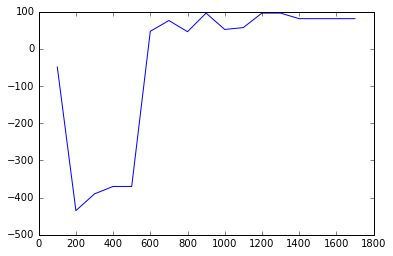

In [24]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [17]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-03-18 23:29:27,435] Making new env: ppaquette/DoomBasic-v0
[2017-03-18 23:29:27,453] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:29:27,811] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.17.29863.video000000.mp4
[2017-03-18 23:29:28,176] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.17.29863.video000001.mp4


Episode finished after 3 timesteps with reward=86.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 1 timesteps with reward=96.0


[2017-03-18 23:29:28,941] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.17.29863.video000008.mp4


Episode finished after 4 timesteps with reward=81.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 9 timesteps with reward=52.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 5 timesteps with reward=76.0


[2017-03-18 23:29:31,806] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 1 timesteps with reward=96.0
mean session score=81.050000.5


In [22]:
from agentnet.utils.persistence import save,load
#save for display
#save(action_layer,"doombasic_dqn_2000.pcl")

In [25]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Homework II
Get it work. We want stable positive score :)

## Bonus assignment II
* Better env
  * Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch __or__ any atari game you want.
  * Try to get `better_than_random` score on any of those environments __(2+++ pts)__
  * Deploy a better network. Doom will likely need some recurrent netsle
     * Find an arcitecture which maxsimizes score __(bonus points depend on your ```mean_reward```)__  
     * Bonus can get large as you approach state-of-the-art
     
* Deploy a different RL algorithm
  * Try at least two RL algorithms which had been learned during the course and try to compare them on ```mean_reward``` with similar training time (**plot** or **table** would be good idea) __(3 pts)__
  * See the note in assignment 4.1 on how to train on-policy
  
  
